# 1. Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# 2. Full Dataset

In [21]:

drift = pd.read_csv('data/drift_data.csv')
excursion_data = pd.read_csv('data/excursion_data.csv')

Our objective is to identify the features that significantly impact the model's performance. To achieve this, we will build an initial model to analyze feature relevance and assess their contribution. We will first experiment with the full dataset, identify key features, and remove variables with little or no significance to the model.

The dataset contains **8 important variables** with strong predictive power across both drift and excursion datasets:
`x1`, `x2`, `x4`, `x5`, `x7`, `x8`, `x9`, `x17`

To further evaluate feature significance, we will expand the drift dataset by including **11 additional variables**:
`x3`, `x6`, `x10`, `x11`, `x12`, `x13`, `x14`, `x15`, `x16`, `x18`, `x19`

To determine the true contribution of these features, we will train two models:

1. **Without Cross-Validation**: A baseline model to quickly identify feature importance.
2. **With Cross-Validation**: A more robust evaluation to validate feature significance and prevent overfitting.

This approach will guide us in refining the dataset and building an optimized, efficient model.

In [ ]:
drift_all = drift.copy()

### Helper Functions

To streamline the workflow, we define helper functions that optimize the code and enhance reusability.

1. `preprocess_data`: Prepares the dataset by scaling features, splitting into training and test sets, and dropping specified columns.

2. `train_evaluate_model`: Trains the given model, generates predictions, and evaluates performance using RMSE and R² metrics.

3. `plot_feature_importance`: Visualizes the importance of each feature based on the trained model's evaluation.

4. `plot_predictions`: Compares actual vs. predicted values for the test set using a scatter plot.

5. `plot_prediction_comp`: Visualizes the prediction performance for both training and test datasets side by side.

In [ ]:
def preprocess_data(df):
    X = df.drop(columns=['outcome'])
    y = df['outcome']
    X_scaled = StandardScaler().fit_transform(X)
    return train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model Training and Evaluation
def train_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return model, rmse, r2, y_pred

def plot_feature_importance(model, feature_names, title, color=None):
    importance = model.feature_importances_
    sorted_idx = np.argsort(importance)[::-1]
    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importance[sorted_idx], color='lightcoral')
    plt.xlabel("Feature Importance")
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

def plot_predictions(y_test, y_pred, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, edgecolor="k")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{title} - Predicted vs Actual")
    plt.grid()
    plt.show()

def plot_prediction_comp(y_train, y_train_pred, y_test, y_test_pred, title=None):
    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=16, fontweight='bold')

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.6, color='blue')
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Train Dataset')

    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, alpha=0.6, color='green')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Test Dataset')

    plt.tight_layout()
    plt.show()

# 3. Drift_all with no cross validation

In this step, we build an initial model using the full dataset without cross-validation. We utilize the XGBoost Regressor with specific hyperparameters to evaluate feature importance and assess the contribution of each variable. The model is trained and evaluated on a train-test split, and the resulting feature importance is visualized.

In [24]:
# Full Dataset - Without Cross-Validation
def full_data_without_cv(dataset):
    print("\n--- Full Dataset: Without Cross-Validation ---")

    # Preprocess the data
    X_train, X_test, y_train, y_test = preprocess_data(dataset)

    # Initialize and train the XGBoost model
    model = xgb.XGBRegressor(
        random_state=42,
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        reg_alpha=1,
        reg_lambda=1
    )

    # Train and evaluate the model
    trained_model, rmse, r2, y_pred = train_evaluate_model(model, X_train, X_test, y_train, y_test)

    # Display results
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

    # Plot feature importance and predictions
    plot_feature_importance(trained_model, dataset.drop(columns=['outcome']).columns, "XGBoost Feature Importance (Full Dataset - Without Cross Validation)", color='blue')

    return trained_model



--- Full Dataset: Without Cross-Validation ---
RMSE: 0.1029
R² Score: 0.9652


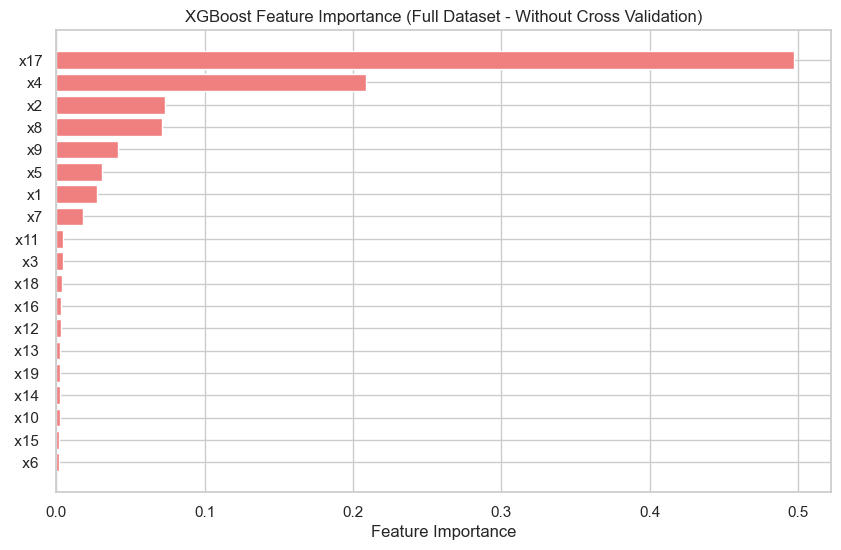

In [25]:
full_model = full_data_without_cv(drift_all)

**Performance Metrics**:

- RMSE: 0.1029
- R² Score: 0.9652

**Feature Importance**:
From the feature importance plot, we observe that the following variables contribute significantly to the model:

- High Significance: `x1`, `x2`, `x4`, `x5`, `x7`, `x8`, `x9`, `x17`
    - Among these, `x17` exhibits the highest contribution.

- Low/No Significance: `x3`, `x6`, `x10`, `x11`, `x12`, `x13`, `x14`, `x15`, `x16`, `x18`, `x19`

# 4. Drift_all with cross validation

In this step, we apply cross-validation to further validate the model's performance and feature significance. We train two models—**XGBoost Regressor (XGB)** and **Random Forest Regressor (RF)**—using specific hyperparameters and evaluated their predictive capabilities across multiple folds. This approach ensures that the results are not biased by a single train-test split and provides a more robust performance assessment.

In [26]:

# Full Dataset - With Cross-Validation (XGBoost & Random Forest)
def full_data_with_cv(dataset):
    print("\n--- Full Dataset: With Cross-Validation ---")

    # Preprocess the data
    X_train, X_test, y_train, y_test = preprocess_data(dataset)

    # Define models and hyperparameters
    models = {
        "XGBoost": xgb.XGBRegressor(random_state=42, objective="reg:squarederror"),
        "Random Forest": RandomForestRegressor(random_state=42)
    }

    param_grids = {
        "XGBoost": {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 6],
            'subsample': [0.8, 1.0],
            'reg_alpha': [0, 1],
            'reg_lambda': [1, 5]
        },
        "Random Forest": {
            'n_estimators': [100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    }

    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    results = []
    best_params = {}

    for name, model in models.items():
        print(f"\nTuning {name}...")
        grid_search = GridSearchCV(model, param_grids[name], scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Best model and evaluation
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Store results
        results.append({'Model': name, 'Test RMSE': rmse, 'Test R2': r2})
        best_params[name] = grid_search.best_params_


        # Plot feature importance and predictions
        plot_feature_importance(best_model, dataset.drop(columns=['outcome']).columns, f"{name} Feature Importance (Full Dataset - Cross Validation)", color='coral')
        plot_predictions(y_test, y_pred, f"{name} (Full Dataset)")

    # Results Summary Table
    results_df = pd.DataFrame(results).set_index('Model')
    print("\nResults Summary:")
    print(results_df)

    print("\nBest Hyperparameters:")
    for model, params in best_params.items():
        print(f"{model}: {params}")

    return results_df, best_params



--- Full Dataset: With Cross-Validation ---

Tuning XGBoost...


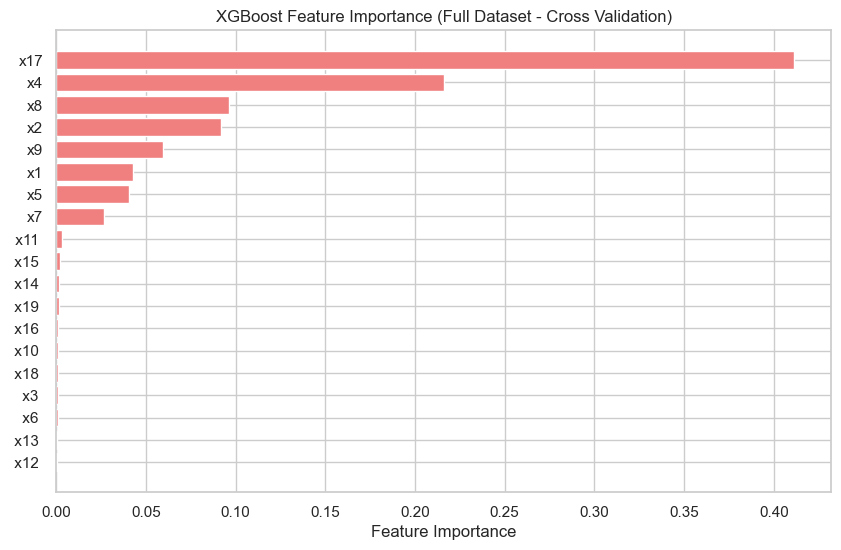

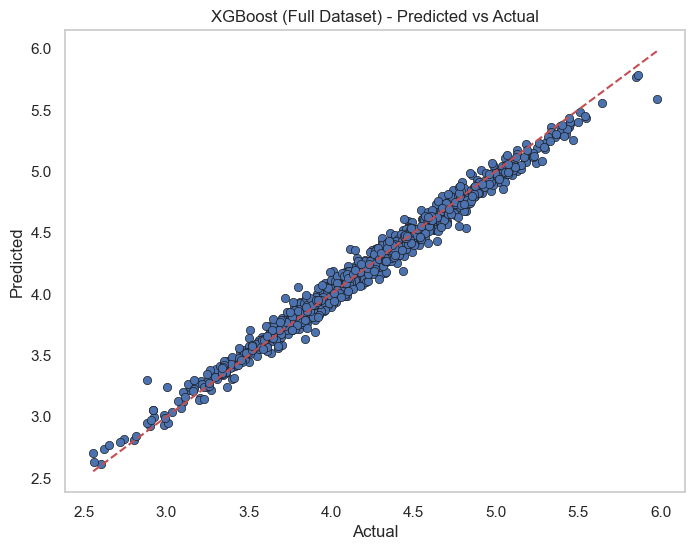


Tuning Random Forest...


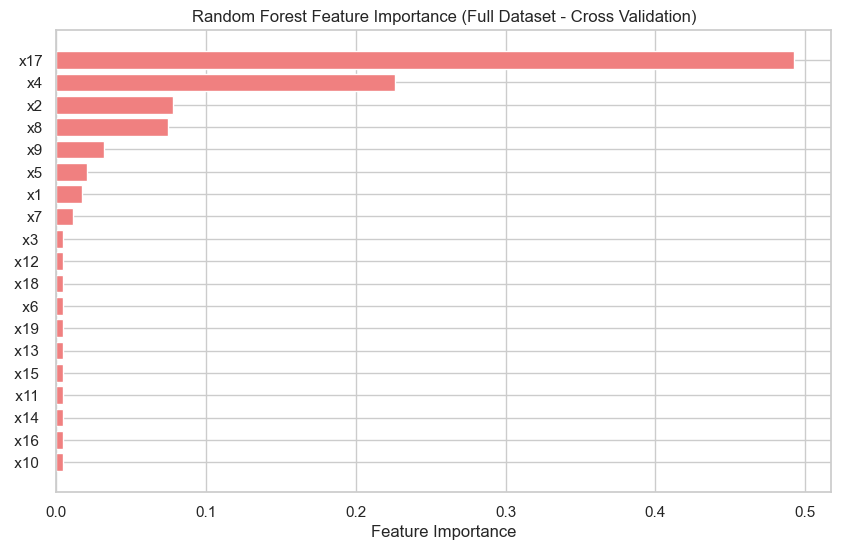

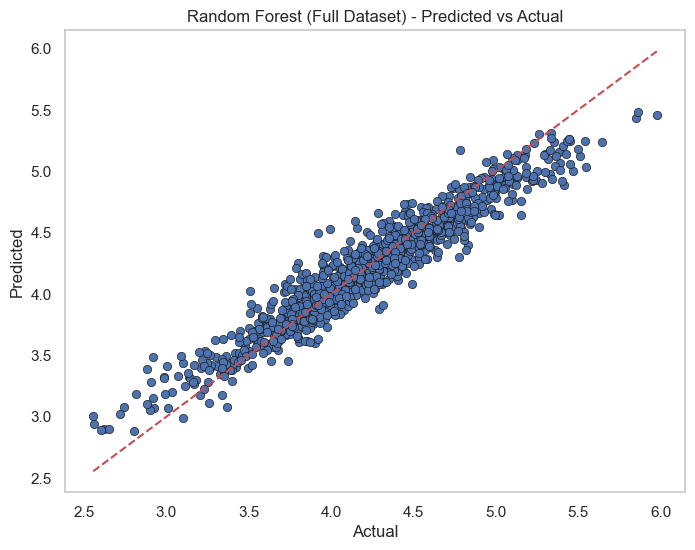


Results Summary:
               Test RMSE   Test R2
Model                             
XGBoost         0.070838  0.983518
Random Forest   0.168566  0.906670

Best Hyperparameters:
XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.8}
Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [27]:
results_df, best_params = full_data_with_cv(drift_all)

<u>Performance Metrics</u>:

- XGBoost:
    - RMSE: **0.070838**, significantly lower than RF
    - R² Score: **0.983518** , explaining 98% of the variance in the dataset.
- Random Forest:
    - RMSE: **0.168566**, higher than XGB
    - R² Score: **0.906670**, lower than XGB
- Predicted vs. Actual Plot: The XGBoost model's predictions closely aligned with actual values, as evidenced by the near-perfect diagonal fit in the plot.

**Feature Importance Analysis**

Both models consistently highlighted the 8 primary variables—`x1`, `x2`, `x4`, `x5`, `x7`, `x8`, `x9`, and `x17`—as the most significant contributors, aligning with the results from the non-cross-validation model. The 11 additional variables (`x3`, `x6`, `x10`, `x11`, `x12`, `x13`, `x14`, `x15`, `x16`, `x18`, `x19`) showed minimal to no contribution.



#### Key Takeaways

1. **XGBoost Outperforms Random Forest**: The XGBoost model outperformed the Random Forest model, achieving a higher R² score and lower RMSE.

2. **Consistent Feature Significance**: Both models reaffirmed that only the 8 primary variables significantly impact model performance.

3. **Feature Reduction for Efficiency**: Given the lack of contribution from the additional 11 variables, they can be safely removed for further analysis, improving computational efficiency without sacrificing model accuracy.


Thus, focusing on the core 8 features ensures a more streamlined and effective simulation.

# 5. Reduced Dataset

To streamline our analysis, we reduced the dataset by retaining only the 8 primary variables identified as significant from both the cross-validation and non-cross-validation models. The 11 additional variables were dropped, as they demonstrated little to no impact on the model's predictive performance.

In [28]:
drift_reduced = drift_all.copy()
drift_reduced.drop(columns=[' x3 ', ' x6 ', ' x10 ', ' x11 ', ' x12 ', ' x13 ',
                              ' x14 ', ' x15 ', ' x16 ', ' x18 ', ' x19 '], axis = 1, inplace=True)

drift_reduced

,x1,x2,x4,x5,x7,x8,x9,x17,outcome
0,22.074510,43.388552,0.392548,133087.641965,1279.809801,96.488548,454.427308,5738.892817,4.557812
1,22.466431,46.124007,0.347548,130526.223504,1265.811747,93.561224,489.796798,5413.432044,4.451564
2,22.224457,44.265334,0.364531,129836.756693,1315.542346,93.071065,458.223601,6035.487909,4.991637
3,21.775400,46.782319,0.392330,129583.905601,1224.718720,92.731523,470.972713,4819.931829,3.383064
4,22.256858,48.236397,0.416964,142911.779559,1333.025445,74.783528,447.075478,5103.054600,2.393557
...,...,...,...,...,...,...,...,...,...
4995,21.475647,45.091891,0.346061,122645.218862,1291.423723,99.624504,431.312481,5520.357231,4.766598
4996,22.209523,46.635975,0.383292,116673.861733,1275.329392,88.280033,428.319450,5452.008878,3.924984
4997,22.523676,48.721557,0.350406,138759.666617,1345.555219,92.790175,441.085514,5379.027701,3.738005
4998,21.529205,44.953498,0.329052,129314.955131,1297.629041,88.804955,417.409961,5997.023188,5.098983


# 6. Hyperparameter Tuning for Reduced Dataset

After identifying the 8 primary variables crucial to the model's performance, the next step involves optimizing the model by fine-tuning hyperparameters. In the previous scenarios, we used a fixed set of parameters for evaluation. Now, we aim to find the best combination of hyperparameters that yields optimal model performance. This process helps us understand how the model behaves under different conditions.

**Approach**

1. Predefined Parameter Set: We start with a predefined set of hyperparameters based on initial observations.

2. Parameter Grid: We define a parameter grid with 25 values for each hyperparameter. To isolate the impact of each parameter, we:
    - Keep other parameters constant.
    - Vary the target hyperparameter across the grid.
    - Record the corresponding RMSE and R² score.
    
3. Performance Evaluation: We visualize the results using colored plots, enabling us to identify the range where optimal values lie.

In [29]:
def evaluate_model(param_name, param_values, X_train, X_test, y_train, y_test):
    results = []

    for value in param_values:
        # Set other parameters constant and vary only one
        model = xgb.XGBRegressor(
            random_state=42,
            n_estimators=100,
            learning_rate=0.1,  
            max_depth=6,
            subsample=0.8,
            reg_alpha=1,
            reg_lambda=1
        )
        setattr(model, param_name, value)  # Set varying parameter

        # Train and predict
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Metrics
        train_r2 = r2_score(y_train, y_train_pred)
        test_r2 = r2_score(y_test, y_test_pred)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Store results
        results.append([f"{param_name} = {value:.3f}", train_r2, test_r2, train_rmse, test_rmse])

    return pd.DataFrame(results, columns=["Hyperparameter", "Train R2", "Test R2", "Train RMSE", "Test RMSE"])

def plot_results(results_dfs, param_grid):
    plt.figure(figsize=(20, 18))
    sns.set(style="whitegrid")
    
    params_to_plot = list(param_grid.keys())
    colors = ['b', 'g', 'r', 'c', 'm']

    for i, param in enumerate(params_to_plot):
        param_values = param_grid[param]
        df = results_dfs[param]

        plt.subplot(5, 2, i * 2 + 1)
        sns.lineplot(x=param_values, y=df["Test RMSE"].astype(float), marker='o', color=colors[i])
        plt.title(f"{param} vs Test RMSE")
        plt.xlabel(param)
        plt.ylabel("Test RMSE")

        plt.subplot(5, 2, i * 2 + 2)
        sns.lineplot(x=param_values, y=df["Test R2"].astype(float), marker='o', color=colors[i])
        plt.title(f"{param} vs Test R²")
        plt.xlabel(param)
        plt.ylabel("Test R²")

    plt.tight_layout()
    plt.show()

def hyper_tune(dataset):
    X_train, X_test, y_train, y_test = preprocess_data(dataset)

    param_grid = {
    "learning_rate": np.linspace(0.0001, 0.5, 25),   # Wider range for learning rate
    "max_depth": np.arange(1, 26, 1),               # Depth from 1 to 30
    "subsample": np.linspace(0.1, 1.0, 25),         # From 10% to 100% sampling
    "reg_alpha": np.linspace(0, 10, 25),            # L1 regularization range
    "reg_lambda": np.linspace(0.1, 20, 25)}          # L2 regularization range

    results_dfs = {
    param: evaluate_model(param, values, X_train, X_test, y_train, y_test) for param, values in param_grid.items()}


    plot_results(results_dfs, param_grid)

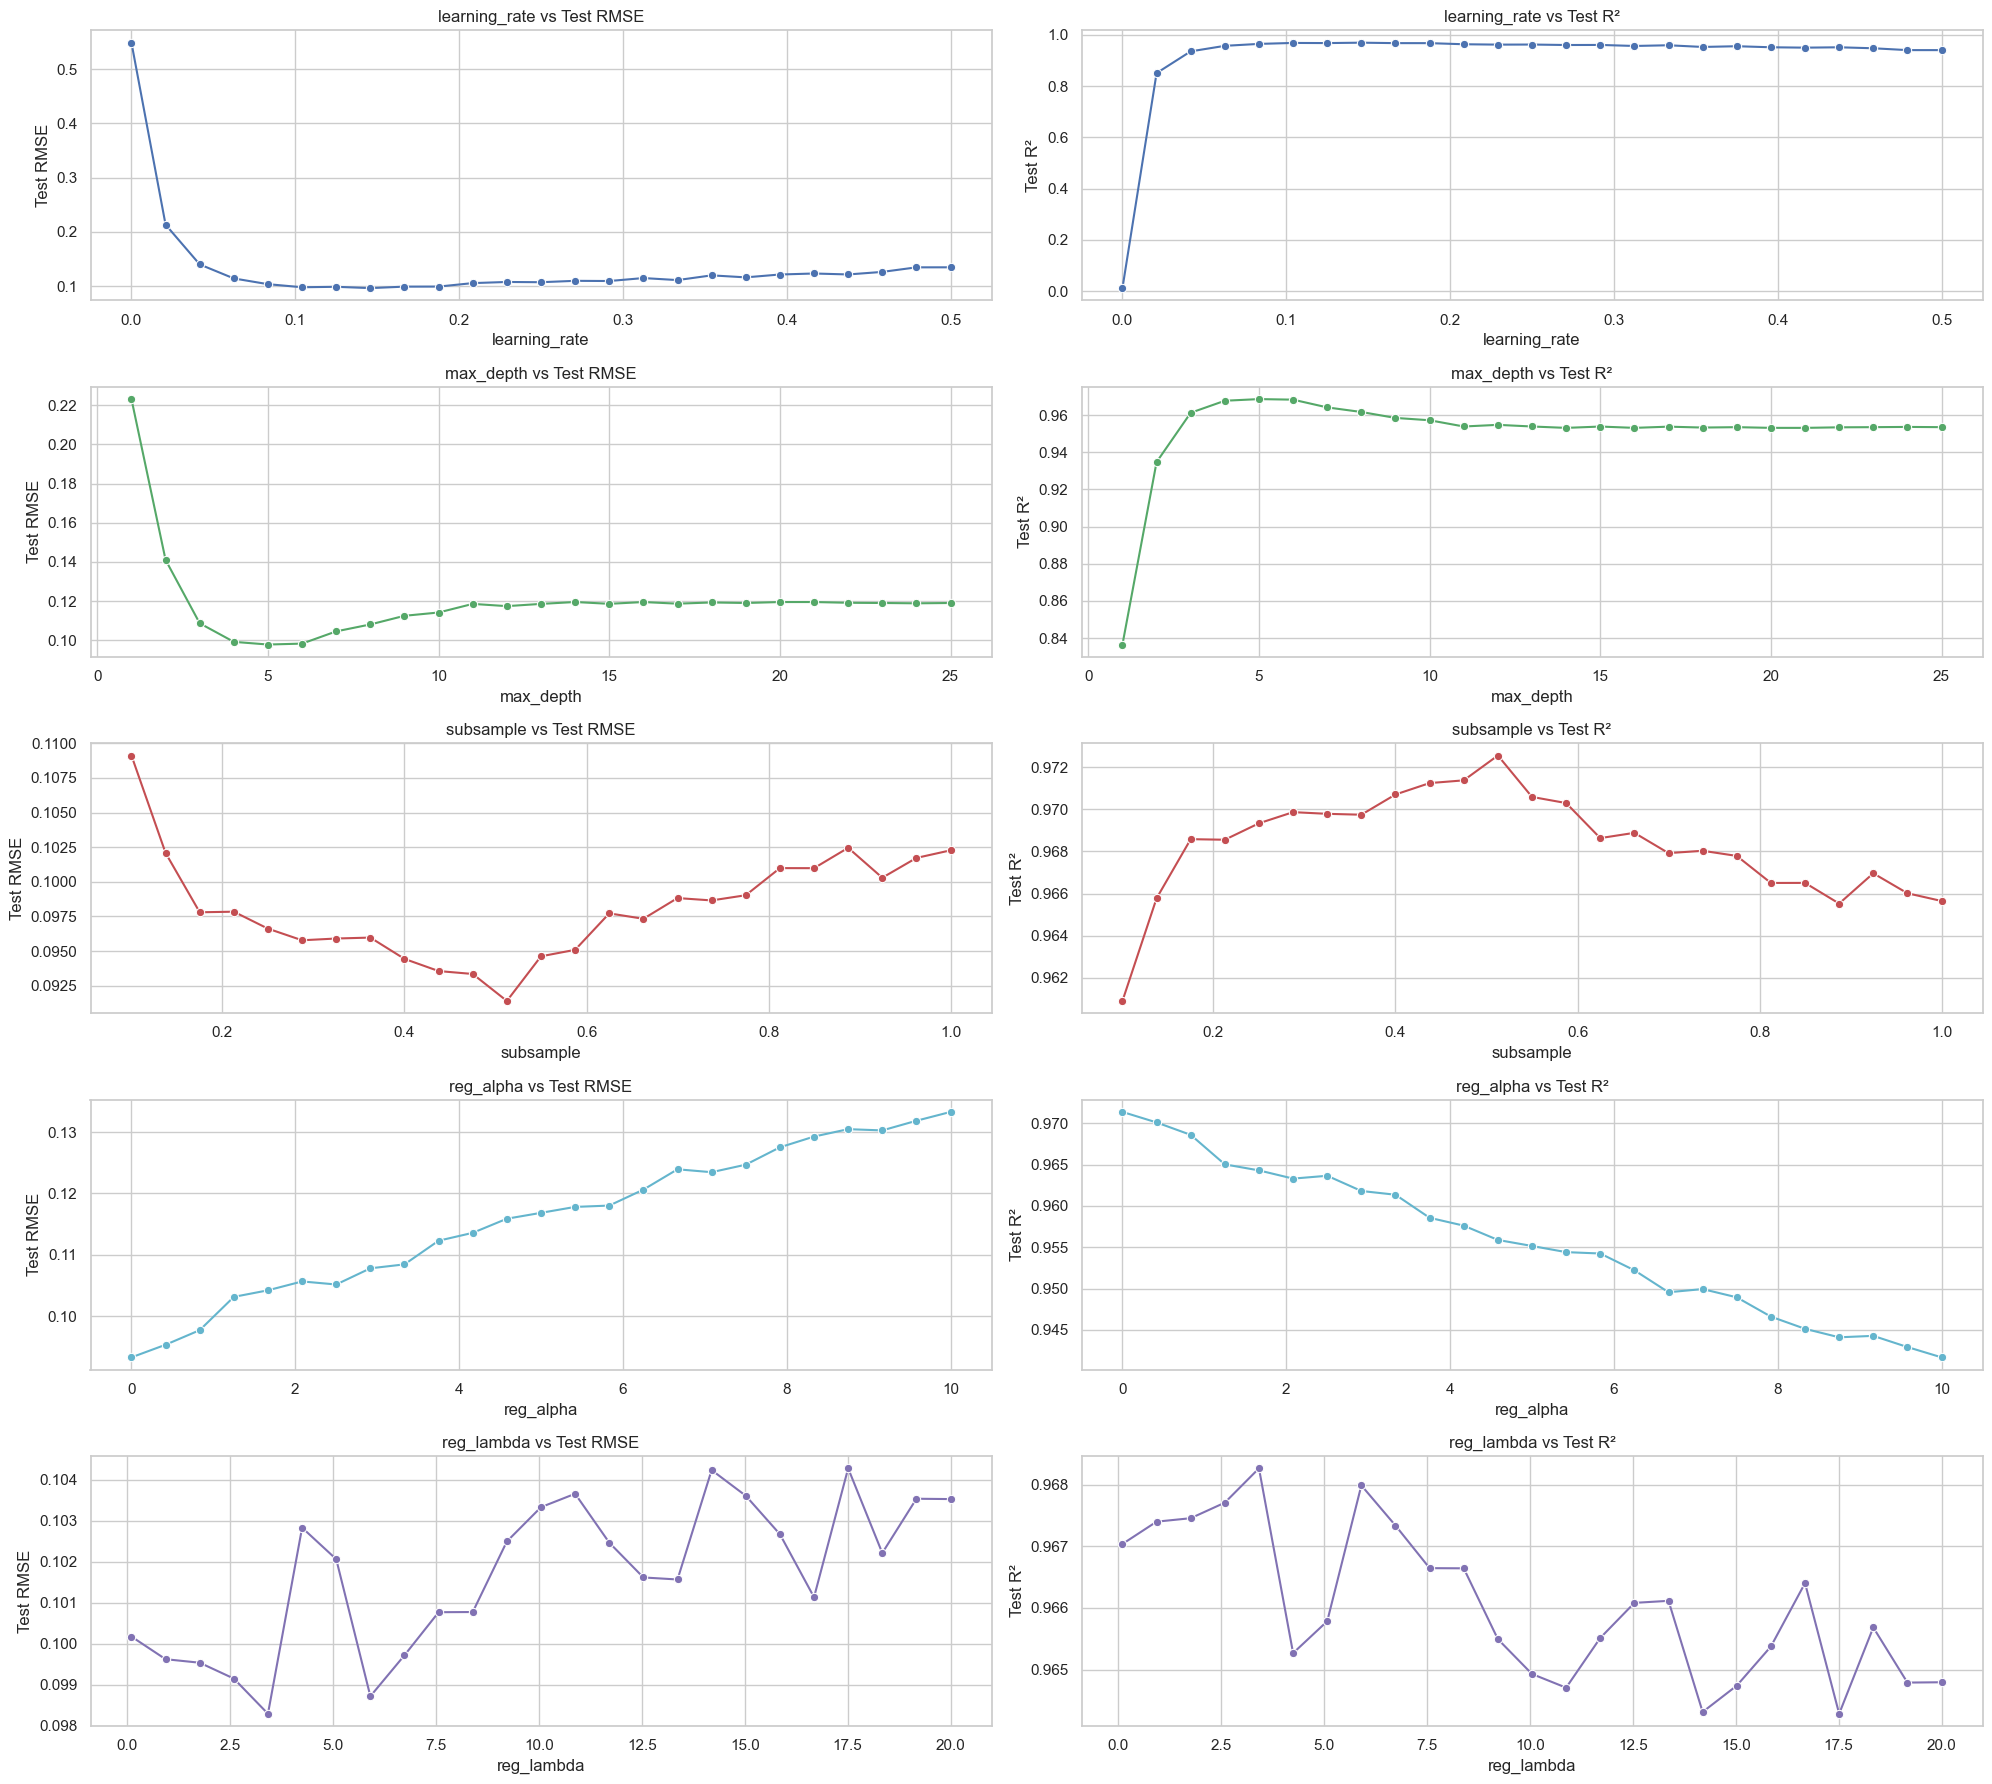

In [30]:
hyper_tune(drift_reduced)

To refine our model, we experimented with five key hyperparameters, analyzing their impact on RMSE and R² score. By observing trends in the plotted results, we identified optimal ranges where the model achieved the lowest RMSE or highest R² values.

**Hyperparameters and Observations:**

1. Learning Rate:
    - We observed a significant RMSE dip around 0.05, followed by a stable range between 0.1 and 0.3, after which RMSE increased.
    - The opposite trend appeared in the R² graph, where the score peaked in the same range.
    - Selected Range: `[0.0, 0.1, 0.2, 0.3]`

2. Max Depth:
    - The lowest RMSE occurred between 2 and 10, with a clear minimum around depth 2 to 7.
    - Increasing depth beyond this range led to diminishing returns and higher RMSE.
    - Selected Range: `[2, 3, 4, 5, 6, 7]`

3. Subsample:
    - RMSE decreased as subsample values increased, reaching a minimum around 0.5, after which the error started rising.
    - Selected Range: `[0.2, 0.3, 0.4, 0.5, 0.6]`

4. Regularization Alpha (L1):

    - RMSE consistently increased with higher L1 values, with the lowest RMSE near 0.
    - Selected Range: `[0, 1, 2]`

5. Regularization Lambda (L2):
    - The RMSE graph showed fluctuations, with clear minima around 2.5 and 3, while a sharp increase occurred near 8.
    - Selected Range: `[0, 0.5, 1, 1.5, 2.5, 3]`
    

By understanding each parameter's effect and selecting optimal ranges, we ensured efficient hyperparameter tuning, balancing model accuracy with computational efficiency.

# 7. Finding Best Model using Grid Search

With the optimal hyperparameter ranges identified, the next step is to find the best-performing model by conducting a Grid Search for both the full dataset and the reduced dataset. This approach allows us to compare the model performance after feature reduction and determine if the reduced dataset maintains predictive power while improving efficiency.

In [31]:
# Helper function to perform grid search and return best model
def perform_grid_search(X, y, param_grid, cv_splits=5):
    
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    model = xgb.XGBRegressor(random_state=42, n_estimators=100)

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=cv,
        n_jobs=-1
    )

    grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_rmse_cv = -grid_search.best_score_
    best_model = grid_search.best_estimator_

    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation RMSE: {best_rmse_cv:.4f}")

    return best_model, best_params, best_rmse_cv

# Helper function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, title):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print("\nFinal Model Evaluation:")
    print(f"Train RMSE: {train_rmse:.4f}, Train R²: {train_r2:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}, Test R²: {test_r2:.4f}")

    plot_prediction_comp(y_train, y_train_pred, y_test, y_test_pred, title)

# Main function to run the entire workflow
def run_xgboost_pipeline(dataset, param_grid, title):
   
    # Preprocess data
    X_train, X_test, y_train, y_test = preprocess_data(dataset)

    # Perform Grid Search
    best_model, best_params, best_rmse_cv = perform_grid_search(X_train, y_train, param_grid)

    # Evaluate final model
    metrics = evaluate_model(best_model, X_train, X_test, y_train, y_test, title)

    return best_model, best_params, metrics

# Hyperparameter grid
param_grid = {
    "learning_rate": [0.0, 0.1, 0.2, 0.3],
    "max_depth": [2, 3, 4, 5, 6, 7],
    "subsample": [0.2, 0.3, 0.4, 0.5, 0.6],
    "reg_alpha": [0, 1, 2],
    "reg_lambda": [0, 0.5, 1, 1.5, 2.5, 3]
}


### Drift_reduced

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.2}
Best Cross-Validation RMSE: 0.0791

Final Model Evaluation:
Train RMSE: 0.0556, Train R²: 0.9898
Test RMSE: 0.0801, Test R²: 0.9789


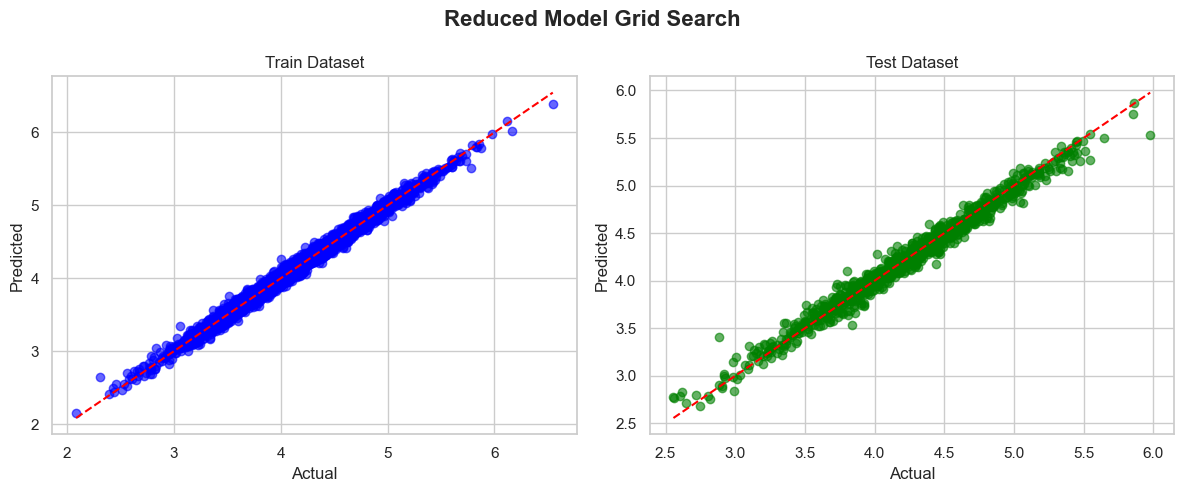

In [32]:
best_model_red, best_params, metrics = run_xgboost_pipeline(drift_reduced, param_grid, title="Reduced Model Grid Search")

From the above plot, it is evident that the model performed exceptionally well in both cases. We achieved an impressive R² score of 98% on the test dataset, indicating that the model explains 98% of the variance in the target variable.

Moreover, the reduced dataset model demonstrated strong predictive power, accurately aligning predictions with actual values. This confirms that the 8 primary variables are sufficient for effective modeling, further validating our feature selection process.

### Drift_all

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'reg_alpha': 0, 'reg_lambda': 3, 'subsample': 0.6}
Best Cross-Validation RMSE: 0.0816

Final Model Evaluation:
Train RMSE: 0.0584, Train R²: 0.9887
Test RMSE: 0.0796, Test R²: 0.9792


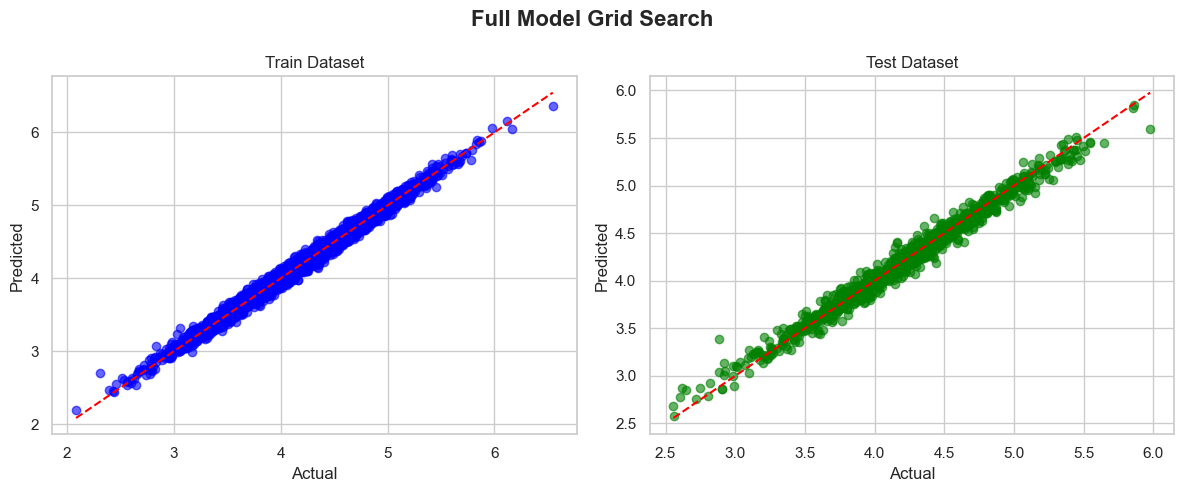

In [33]:
best_model_full, best_params, metrics = run_xgboost_pipeline(drift_all, param_grid, title="Full Model Grid Search")

A similar observation can be made with the full dataset, where the model also achieved an R² score of 98%, accurately predicting the target variable.

Comparing results from both datasets, we found that despite minor variations in hyperparameters, the R² score, RMSE, and cross-validation RMSE remained nearly identical. This further reinforces the conclusion that the additional variables have no significant impact on the model's performance.

**Key Observations**

1. Reduced Dataset Efficiency:
    - The reduced dataset model performed on par with the full dataset model, with no significant drop in accuracy.
    - This confirms that the 8 primary variables effectively capture the dataset's variability, rendering the additional 11 variables redundant.

2. Performance Metrics:

    - The 98% R² score highlights that the model explains 98% of the variance in the target variable.
    - The Predicted vs. Actual plots displayed a strong linear relationship, further validating the model's predictive power.

3. Computational Efficiency:

    - The reduced dataset model not only maintained high performance but also significantly lowered computational time and resource usage, making it the preferred choice for future analysis.


**Conclusion**:

The results demonstrate that the 8 primary variables are sufficient for achieving optimal model performance. The additional variables contribute little to no value, and their exclusion improves computational efficiency without sacrificing accuracy. Therefore, moving forward, the reduced dataset approach offers a more streamlined, cost-effective, and equally precise solution for modeling and analysis.

# 8. Prediction on the Excursion Data

Now, we test how well our model performs on the Excursion dataset.

Since we observed no significant difference between the full dataset model and the reduced dataset model, we opt for the reduced dataset model to ensure computational efficiency. Additionally, the Excursion dataset does not contain the extra 11 variables, making the reduced model the natural choice for evaluation.

To proceed, we use the best model obtained through Grid Search on the reduced dataset and apply it to the Excursion dataset for further analysis.


In [34]:
best_model_red

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [35]:
ex_data = excursion_data.copy()  

X_ex = ex_data.drop(columns=['outcome'])
y_ex_actual = ex_data['outcome']  

X_ex_scaled = StandardScaler().fit_transform(X_ex) 

final_model = best_model_red 
y_ex_pred = final_model.predict(X_ex_scaled)

# Calculate RMSE and R^2
rmse_ex = np.sqrt(mean_squared_error(y_ex_actual, y_ex_pred))
r2_ex = r2_score(y_ex_actual, y_ex_pred)

print(f"RMSE: {rmse_ex:.4f}")
print(f"R^2: {r2_ex:.4f}")

RMSE: 3.5850
R^2: -15.4526


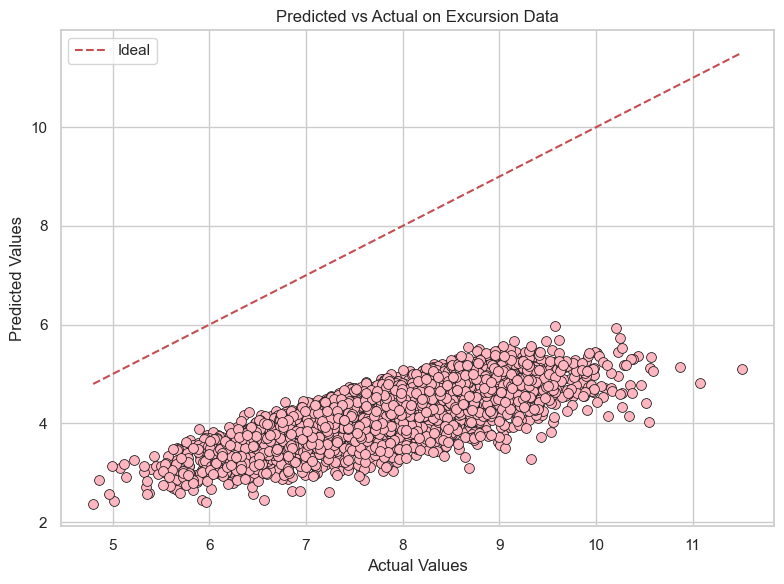

In [36]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_ex_actual, y=y_ex_pred, color="lightpink", edgecolor="k", s=50)
plt.plot(
    [y_ex_actual.min(), y_ex_actual.max()],
    [y_ex_actual.min(), y_ex_actual.max()],
    '--r', linewidth=1.5, label="Ideal"
)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual on Excursion Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Performance on Excursion Data**

From the prediction results and evaluation metrics, we observe that our model did not perform well on the Excursion dataset.

- The R² score is approximately -15, indicating that the model fails to explain the variance in this dataset.
- The RMSE is around 3.5, which suggests a significant error in predictions.
- The Predicted vs. Actual plot shows that the data points deviate heavily from the ideal regression line, confirming poor predictive accuracy.

**Key Takeaways**

- The poor performance suggests that historical data alone is insufficient to model extreme excursion cases.
- In real-world industrial settings, additional contextual parameters and external factors likely influence outcomes.
- This highlights the limitations of our current model in handling extreme cases and suggests the need for more robust modeling approaches, such as incorporating domain-specific variables or exploring alternative modeling techniques.